## How far are we from solving the 2D & 3D Face Alignment problem?

In [10]:
import face_alignment
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage import io

# 변수 초기화

In [11]:
from __future__ import print_function
import os
import torch
from torch.utils.model_zoo import load_url
from enum import Enum
from skimage import io
from skimage import color
import numpy as np
import cv2
try:
    import urllib.request as request_file
except BaseException:
    import urllib as request_file
from models import FAN, ResNetDepth
from utils import *

device='cpu'
flip_input = False
face_detector='sfd'
# https://arxiv.org/pdf/1708.05237.pdf
verbose=False
image_path = './test/assets/aflw-test.jpg'
image = io.imread(image_path)

# 입력 영상

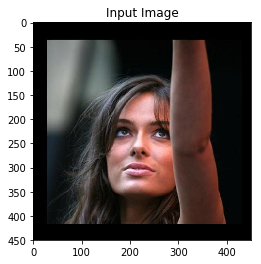

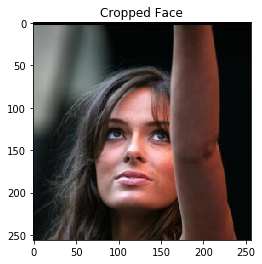

[155.17755   137.82916   309.43936   357.5605      0.9999676]


In [12]:
if image.ndim == 2:
    image = color.gray2rgb(image)
elif image.ndim == 4:
    image = image[..., :3]

plt.imshow(image)
plt.title('Input Image')
plt.show()
# 얼굴 검출기를 불러옵니다.
face_detector_module = __import__('face_alignment.detection.' + face_detector,
                                  globals(), locals(), [face_detector], 0)
face_detector = face_detector_module.FaceDetector(device=device, verbose=verbose)
detected_faces = face_detector.detect_from_image(image[..., ::-1].copy())
if len(detected_faces) == 0:
    print("Warning: No faces were detected.")
d= detected_faces[-1]
center = torch.FloatTensor(
            [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
center[1] = center[1] - (d[3] - d[1]) * 0.12
scale = (d[2] - d[0] + d[3] - d[1]) / face_detector.reference_scale

# 얼굴 사진부분 자르기
inp = crop(image, center, scale)

plt.imshow(inp)
plt.title('Cropped Face')
plt.show()
print(d)

# FAN 네트워크 parameters

In [13]:
from __future__ import print_function
import os
import torch
from torch.utils.model_zoo import load_url
from enum import Enum
from skimage import io
from skimage import color
import numpy as np
import cv2
try:
    import urllib.request as request_file
except BaseException:
    import urllib as request_file
from models import FAN, ResNetDepth
from utils import *


class LandmarksType(Enum):
    
    # Enum class defining the type of landmarks to detect.

    # ``_2D`` - the detected points ``(x,y)`` are detected in a 2D space and follow the visible contour of the face
    # ``_2halfD`` - this points represent the projection of the 3D points into 3D
    # ``_3D`` - detect the points ``(x,y,z)``` in a 3D space
    _2D = 1
    _2halfD = 2
    _3D = 3


class NetworkSize(Enum):
    # TINY = 1
    # SMALL = 2
    # MEDIUM = 3
    LARGE = 4

def __new__(cls, value):
    member = object.__new__(cls)
    member._value_ = value
    return member

def __int__(self):
    return self.value

models_urls = {
    '2DFAN-4': 'https://www.adrianbulat.com/downloads/python-fan/2DFAN4-11f355bf06.pth.tar',
    '3DFAN-4': 'https://www.adrianbulat.com/downloads/python-fan/3DFAN4-7835d9f11d.pth.tar',
    'depth': 'https://www.adrianbulat.com/downloads/python-fan/depth-2a464da4ea.pth.tar',
}

In [14]:
# 네트워크 초기화
network_size= 4
landmarks_type = LandmarksType._2D
landmarks = []
face_alignment_net = FAN(network_size)
if landmarks_type == LandmarksType._3D:
    network_name = '2DFAN-' + str(network_size)
else:
    network_name = '3DFAN-' + str(network_size)

fan_weights = load_url(models_urls[network_name], map_location=lambda storage, loc: storage)
face_alignment_net.load_state_dict(fan_weights)
face_alignment_net.to(device)
face_alignment_net.eval()

for i, d in enumerate(detected_faces):
    center = torch.FloatTensor(
                [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
    center[1] = center[1] - (d[3] - d[1]) * 0.12
    scale = (d[2] - d[0] + d[3] - d[1]) / face_detector.reference_scale

    # crop the face
    inp = crop(image, center, scale)

    # Get_landmarks_from_image
    inp = torch.from_numpy(inp.transpose((2, 0, 1))).float()
    inp = inp.to(device)
    inp.div_(255.0).unsqueeze_(0)

    out = face_alignment_net(inp)[-1].detach()
    if flip_input:
        out += flip(face_alignment_net(flip(inp))
                    [-1].detach(), is_label=True)
    out = out.cpu()

    pts, pts_img = get_preds_fromhm(out, center, scale)
    pts, pts_img = pts.view(68, 2) * 4, pts_img.view(68, 2)

    if landmarks_type == LandmarksType._3D:
        heatmaps = np.zeros((68, 256, 256), dtype=np.float32)
        for i in range(68):
            if pts[i, 0] > 0:
                heatmaps[i] = draw_gaussian(heatmaps[i], pts[i], 2)
        heatmaps = torch.from_numpy(heatmaps).unsqueeze_(0)
        heatmaps = heatmaps.to(device)
        depth_pred = depth_prediciton_net(torch.cat((inp, heatmaps), 1)).data.cpu().view(68, 1)
        pts_img = torch.cat((pts_img, depth_pred * (1.0 / (256.0 / (200.0 * scale)))), 1)

    landmarks.append(pts_img.numpy())
preds = landmarks[-1]
print(preds.shape)

(68, 2)


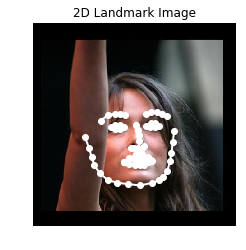

In [15]:
#TODO: Make this nice
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)
ax.plot(preds[0:17,0],preds[0:17,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[17:22,0],preds[17:22,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[22:27,0],preds[22:27,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[27:31,0],preds[27:31,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[31:36,0],preds[31:36,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[36:42,0],preds[36:42,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[42:48,0],preds[42:48,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[48:60,0],preds[48:60,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[60:68,0],preds[60:68,1],marker='o',markersize=6,linestyle='-',color='w',lw=2) 
ax.axis('off')
plt.title('2D Landmark Image')
ax.set_xlim(ax.get_xlim()[::-1])
plt.show()

In [16]:
landmarks_type = LandmarksType._3D

# Initialiase the depth prediciton network
if landmarks_type == LandmarksType._3D:
    depth_prediciton_net = ResNetDepth()

    depth_weights = load_url(models_urls['depth'], map_location=lambda storage, loc: storage)
    depth_dict = {
        k.replace('module.', ''): v for k,
        v in depth_weights['state_dict'].items()}
    depth_prediciton_net.load_state_dict(depth_dict)

    depth_prediciton_net.to(device)
    depth_prediciton_net.eval()

for i, d in enumerate(detected_faces):
    center = torch.FloatTensor(
                [d[2] - (d[2] - d[0]) / 2.0, d[3] - (d[3] - d[1]) / 2.0])
    center[1] = center[1] - (d[3] - d[1]) * 0.12
    scale = (d[2] - d[0] + d[3] - d[1]) / face_detector.reference_scale

    #crop the face
    inp = crop(image, center, scale)

    # Get_landmarks_from_image
    inp = torch.from_numpy(inp.transpose((2, 0, 1))).float()
    inp = inp.to(device)
    inp.div_(255.0).unsqueeze_(0)

    out = face_alignment_net(inp)[-1].detach()
    if flip_input:
        out += flip(face_alignment_net(flip(inp))
                    [-1].detach(), is_label=True)
    out = out.cpu()

    pts, pts_img = get_preds_fromhm(out, center, scale)
    pts, pts_img = pts.view(68, 2) * 4, pts_img.view(68, 2)

    if landmarks_type == LandmarksType._3D:
        heatmaps = np.zeros((68, 256, 256), dtype=np.float32)
        for i in range(68):
            if pts[i, 0] > 0:
                heatmaps[i] = draw_gaussian(heatmaps[i], pts[i], 2)
        heatmaps = torch.from_numpy(heatmaps).unsqueeze_(0)
        heatmaps = heatmaps.to(device)
        depth_pred = depth_prediciton_net(torch.cat((inp, heatmaps), 1)).data.cpu().view(68, 1)
        pts_img = torch.cat((pts_img, depth_pred * (1.0 / (256.0 / (200.0 * scale)))), 1)

    landmarks.append(pts_img.numpy())
preds = landmarks[-1]
print(preds.shape)

(68, 3)


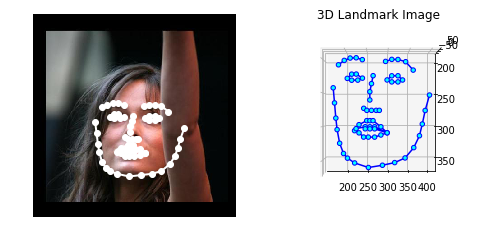

In [17]:
#TODO: Make this nice
fig = plt.figure(figsize=plt.figaspect(.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(image)
ax.plot(preds[0:17,0],preds[0:17,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[17:22,0],preds[17:22,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[22:27,0],preds[22:27,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[27:31,0],preds[27:31,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[31:36,0],preds[31:36,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[36:42,0],preds[36:42,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[42:48,0],preds[42:48,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[48:60,0],preds[48:60,1],marker='o',markersize=6,linestyle='-',color='w',lw=2)
ax.plot(preds[60:68,0],preds[60:68,1],marker='o',markersize=6,linestyle='-',color='w',lw=2) 
ax.axis('off')

if landmarks_type == LandmarksType._3D:
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.scatter(preds[:,0]*1.2,preds[:,1],preds[:,2],c="cyan", alpha=1.0, edgecolor='b')
    ax.plot3D(preds[:17,0]*1.2,preds[:17,1], preds[:17,2], color='blue' )
    ax.plot3D(preds[17:22,0]*1.2,preds[17:22,1],preds[17:22,2], color='blue')
    ax.plot3D(preds[22:27,0]*1.2,preds[22:27,1],preds[22:27,2], color='blue')
    ax.plot3D(preds[27:31,0]*1.2,preds[27:31,1],preds[27:31,2], color='blue')
    ax.plot3D(preds[31:36,0]*1.2,preds[31:36,1],preds[31:36,2], color='blue')
    ax.plot3D(preds[36:42,0]*1.2,preds[36:42,1],preds[36:42,2], color='blue')
    ax.plot3D(preds[42:48,0]*1.2,preds[42:48,1],preds[42:48,2], color='blue')
    ax.plot3D(preds[48:,0]*1.2,preds[48:,1],preds[48:,2], color='blue' )
    ax.view_init(elev=90., azim=90.)

ax.set_xlim(ax.get_xlim()[::-1])
plt.title('3D Landmark Image')
plt.show()